In [1]:
import os
import sys
from pathlib import Path
project_root = os.path.join('/home/shashank/research/hyper/HyperPPO')
os.chdir(project_root)
%pwd 

'/home/shashank/research/hyper/HyperPPO'

In [2]:

import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

from sample_factory.enjoy import *
from sf_examples.mujoco_parallel.enjoy_mujoco import *

/home/shashank/miniconda3/envs/hyper/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
env = "mujoco_halfcheetah"
train_dir = "train_dir_final/mujoco/mujoco_2048"
experiment = "00_mujoco_see_1985264_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased"


eval_str = "python -m sf_examples.mujoco_parallel.enjoy_mujoco"
eval_str += f" --env {env}"
eval_str += f" --train_dir {train_dir}"
eval_str += f" --experiment {experiment}"

argv = eval_str.split()[3:]

cfg = parse_mujoco_cfg(evaluation=True, argv=argv)
register_mujoco_components()

In [4]:
verbose = False

cfg = load_from_checkpoint(cfg)


eval_env_frameskip: int = cfg.env_frameskip if cfg.eval_env_frameskip is None else cfg.eval_env_frameskip
assert (
    cfg.env_frameskip % eval_env_frameskip == 0
), f"{cfg.env_frameskip=} mmilestoneust be divisible by {eval_env_frameskip=}"
render_action_repeat: int = cfg.env_frameskip // eval_env_frameskip
cfg.env_frameskip = cfg.eval_env_frameskip = eval_env_frameskip
log.debug(f"Using frameskip {cfg.env_frameskip} and {render_action_repeat=} for evaluation")

cfg.num_envs = 1
cfg.env_agents = 8*3
cfg.max_num_episodes = 40
cfg.eval_deterministic = True
num = 350

# render_mode = "human"
render_mode = None
if cfg.save_video:
    render_mode = "rgb_array"
elif cfg.no_render:
    render_mode = None

env = make_env_func_batched(
    cfg, env_config=AttrDict(worker_index=0, vector_index=0, env_id=0), render_mode=render_mode
)
env_info = extract_env_info(env, cfg)

if hasattr(env.unwrapped, "reset_on_init"):
    # reset call ruins the demo recording for VizDoom
    env.unwrapped.reset_on_init = False

[2023-09-11 05:08:50,434][04412] Loading existing experiment configuration from train_dir_final/mujoco/mujoco_2048/00_mujoco_see_1985264_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/config.json
[2023-09-11 05:08:50,435][04412] Overriding arg 'train_dir' with value 'train_dir_final/mujoco/mujoco_2048' passed from command line
[2023-09-11 05:08:50,435][04412] Adding new argument 'fps'=0 that is not in the saved config file!
[2023-09-11 05:08:50,435][04412] Adding new argument 'eval_env_frameskip'=None that is not in the saved config file!
[2023-09-11 05:08:50,436][04412] Adding new argument 'no_render'=False that is not in the saved config file!
[2023-09-11 05:08:50,436][04412] Adding new argument 'save_video'=False that is not in the saved config file!
[2023-09-11 05:08:50,436][04412] Adding new argument 'video_frames'=1000000000.0 that is not in the saved config file!
[2023-09-11 05:08:50,437][04412] Adding new argument 'video_name'=None that is not in the saved config

In [5]:

def eval_for_given_arch(num_eval_envs, eval_env, actor_critic, env_info, cfg, device):
    episode_rewards = np.zeros((num_eval_envs))
    obs, infos = eval_env.reset()
    rnn_states = torch.zeros([num_eval_envs, get_rnn_size(cfg)], dtype=torch.float32, device=device)
    episode_reward = None
    finished_episode = [False for _ in range(num_eval_envs)]
    with torch.no_grad():
        while not all(finished_episode):
            normalized_obs = prepare_and_normalize_obs(actor_critic, obs)
            policy_outputs = actor_critic(normalized_obs, rnn_states, sample_actions=True)
            
            # sample actions from the distribution by default
            actions = policy_outputs["actions"]

            # actions shape should be [num_agents, num_actions] even if it's [1, 1]
            if actions.ndim == 1:
                actions = unsqueeze_tensor(actions, dim=-1)
            actions = preprocess_actions(env_info, actions)



            obs, rew, terminated, truncated, infos = eval_env.step(actions)
            dones = make_dones(terminated, truncated)
            infos = [{} for _ in range(env_info.num_agents)] if infos is None else infos

            if episode_reward is None:
                episode_reward = rew.float().clone()
            else:
                episode_reward += rew.float()

            dones = dones.cpu().numpy()
            for agent_i, done_flag in enumerate(dones):
                if done_flag:
                    finished_episode[agent_i] = True
                    rew = episode_reward[agent_i].item()
                    episode_rewards[agent_i] = rew



                    episode_reward[agent_i] = 0

                    # reward_list.append(true_objective)
    return episode_rewards, finished_episode

In [6]:

def enjoy(cfg):

    actor_critic = create_actor_critic(cfg, env.observation_space, env.action_space)
    actor_critic.eval()

    device = torch.device("cpu" if cfg.device == "cpu" else "cuda")
    actor_critic.model_to_device(device)

    policy_id = cfg.policy_index
    name_prefix = dict(latest="checkpoint", best="best")[cfg.load_checkpoint_kind]
    checkpoints = Learner.get_checkpoints(Learner.checkpoint_dir(cfg, policy_id), f"{name_prefix}_*")


    if cfg.milestone_name is None:
        checkpoint_dict = Learner.load_checkpoint(checkpoints, device)
        milestone_to_load = checkpoint_dict["model"]
    else:
        milestone_dir = os.path.join(cfg.train_dir, cfg.experiment, "checkpoint_p0", "milestones")
        milestones = Learner.get_checkpoints(milestone_dir, "checkpoint_*")
        milestone_to_load = [milestone for milestone in milestones if cfg.milestone_name in milestone][0]
        checkpoint_dict = Learner.load_checkpoint([milestone_to_load], device)

    actor_critic.load_state_dict(checkpoint_dict["model"])
    ghn = actor_critic.actor_encoder.ghn
    ghn.eval()    

    experiment_dir = os.path.join(cfg.train_dir, cfg.experiment)
    dataframe_dir = os.path.join(experiment_dir, "dataframes")
    if not os.path.exists(dataframe_dir):
        os.makedirs(dataframe_dir)
    dataframe_name = os.path.join(dataframe_dir, f"{cfg.milestone_name}.csv")

    if os.path.exists(dataframe_name):
        print("Dataframe already exists")
        return

    list_of_test_archs = actor_critic.actor_encoder.list_of_arcs
    list_of_test_arch_indices = actor_critic.actor_encoder.list_of_arc_indices
    # self.list_of_test_shape_inds = self.actor_critic.actor_encoder.list_of_shape_inds
    list_of_test_shape_inds = torch.stack([actor_critic.actor_encoder.list_of_shape_inds[index][0:11] for k,index in enumerate(list_of_test_arch_indices)])
    test_results_df = pd.DataFrame(columns=['arch', 'num_params','reward'])
    test_results_df['arch'] = [list_of_test_archs[i] for i in list_of_test_arch_indices]
    test_results_df['num_params'] = [actor_critic.actor_encoder.get_params(list_of_test_archs[i]) for i in list_of_test_arch_indices]


    archs_per_num = len(list_of_test_arch_indices) // num  
    episode_rewards = np.zeros((len(list_of_test_arch_indices)))

    for k in tqdm(range(num)):
        actor_critic.actor_encoder.set_graph(list_of_test_arch_indices[k*archs_per_num:(k+1)*archs_per_num], list_of_test_shape_inds[k*archs_per_num:(k+1)*archs_per_num])
        episode_rewards_per_num, finished_episode_per_num = eval_for_given_arch(env.num_agents, env, actor_critic, env_info, cfg, device)
        episode_rewards[k*archs_per_num:(k+1)*archs_per_num] = episode_rewards_per_num.reshape(archs_per_num, env.num_agents//archs_per_num).mean(1)
    
    test_results_df['reward'] = episode_rewards
    test_results_df.to_csv(dataframe_name, index=False)
    # return test_results_df



In [7]:
folder_to_ignore = [
    "02_mujoco_see_7377834_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased",
    "00_mujoco_see_1985264_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased",
    "01_mujoco_see_6657756_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased",
    "00_mujoco_see_2665409_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased"
]

def plot_cdf(train_dir, max_num_seeds = 6):
    folders = os.listdir(train_dir)
    folders.sort(key=lambda x: int(x.split("_")[0]))
    ys = []
    xs = []
    k = 0
    for folder in folders:
        if folder in folder_to_ignore:
            continue

        path_to_dataframe_folder = os.path.join(train_dir, folder,"dataframes")

        # if path_to_dataframe_folder is not a directory, skip it
        if not os.path.isdir(path_to_dataframe_folder):
            continue
        list_all_dataframes = os.listdir(path_to_dataframe_folder)
        # sort the list of dataframes by 3rd element after splitting by "_" and ignoring the ".csv" extension
        list_all_dataframes.sort(key=lambda x: int(x.split("_")[2].split(".")[0]))

        if len(list_all_dataframes) == 0:
            continue

        # get the path of the last dataframe
        path_to_last_dataframe = os.path.join(path_to_dataframe_folder, list_all_dataframes[-1])
        # print(path_to_last_dataframe)
        # read the last dataframe
        df = pd.read_csv(path_to_last_dataframe)

        rewards = df["reward"]
        # sort the rewards in descending order
        rewards = rewards.sort_values(ascending=False)
        max_reward = rewards.iloc[0]
        min_reward = rewards.iloc[-1]

        # create a cdf plot for the reward column
        x = np.linspace(-1000, max_reward, len(rewards))
        y = []
        for i in range(len(x)):
            x[i] = int(x[i])
            y.append(len(rewards) - (len(rewards[rewards <= x[i]])))
        ys.append(y)
        xs.append(x)
        k += 1
        if k == max_num_seeds:
            break

    # plot the cdf with mean and std deviation with color area
    num_agents = train_dir.split("_")[-1]
    # make legend as per the number of agents
    mean = np.mean(ys, axis=0)
    std = np.std(ys, axis=0)
    plt.plot(xs[0], mean, label=num_agents)
    plt.fill_between(xs[0], mean - std, mean + std, color='b', alpha=.1)


    # name the axes
    plt.xlabel("reward")
    plt.ylabel("number of policies")


In [8]:
for mujoco_dir in ["mujoco_2048", "mujoco_1024", "mujoco_512", "mujoco_256"]:
    # iterate through the train_dir and plot the cdf for each seed
    train_dir = f"train_dir_final/mujoco/{mujoco_dir}"
    cfg.train_dir = train_dir
    experiments = os.listdir(train_dir)
    experiments.sort(key=lambda x: int(x.split("_")[0]))
    for experiment in experiments:
        cfg.experiment = experiment

        # list all milestones
        milestones = os.listdir(os.path.join(train_dir, experiment, "checkpoint_p0", "milestones"))
        milestones.sort(key=lambda x: int(x.split("_")[1]))

        # get the last milestone
        cfg.milestone_name = milestones[-1]

        # enjoy the last milestone
        enjoy(cfg)

[2023-09-11 05:08:56,547][04412] RunningMeanStd input shape: (17,)
[2023-09-11 05:08:56,589][04412] RunningMeanStd input shape: (1,)
[2023-09-11 05:08:59,869][04412] Loading state from checkpoint train_dir_final/mujoco/mujoco_2048/00_mujoco_see_1985264_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/checkpoint_p0/milestones/checkpoint_000096088_98394112.pth...
[2023-09-11 05:08:59,985][04412] RunningMeanStd input shape: (17,)
[2023-09-11 05:08:59,987][04412] RunningMeanStd input shape: (1,)


Dataframe already exists


[2023-09-11 05:09:01,653][04412] Loading state from checkpoint train_dir_final/mujoco/mujoco_2048/01_mujoco_see_7725366_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/checkpoint_p0/milestones/checkpoint_000088248_90365952.pth...
[2023-09-11 05:09:01,768][04412] RunningMeanStd input shape: (17,)
[2023-09-11 05:09:01,772][04412] RunningMeanStd input shape: (1,)


Dataframe already exists


[2023-09-11 05:09:03,423][04412] Loading state from checkpoint train_dir_final/mujoco/mujoco_2048/02_mujoco_see_7377834_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/checkpoint_p0/milestones/checkpoint_000088128_90243072.pth...
[2023-09-11 05:09:03,547][04412] RunningMeanStd input shape: (17,)
[2023-09-11 05:09:03,551][04412] RunningMeanStd input shape: (1,)


Dataframe already exists


[2023-09-11 05:09:05,212][04412] Loading state from checkpoint train_dir_final/mujoco/mujoco_2048/03_mujoco_see_7621403_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/checkpoint_p0/milestones/checkpoint_000096104_98410496.pth...
[2023-09-11 05:09:05,330][04412] RunningMeanStd input shape: (17,)
[2023-09-11 05:09:05,332][04412] RunningMeanStd input shape: (1,)


Dataframe already exists


[2023-09-11 05:09:06,978][04412] Loading state from checkpoint train_dir_final/mujoco/mujoco_1024/00_mujoco_see_2665409_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/checkpoint_p0/milestones/checkpoint_000120320_61603840.pth...
[2023-09-11 05:09:07,103][04412] RunningMeanStd input shape: (17,)
[2023-09-11 05:09:07,106][04412] RunningMeanStd input shape: (1,)


Dataframe already exists


[2023-09-11 05:09:08,741][04412] Loading state from checkpoint train_dir_final/mujoco/mujoco_1024/01_mujoco_see_6657756_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/checkpoint_p0/milestones/checkpoint_000117904_60366848.pth...
[2023-09-11 05:09:08,860][04412] RunningMeanStd input shape: (17,)
[2023-09-11 05:09:08,862][04412] RunningMeanStd input shape: (1,)


Dataframe already exists


[2023-09-11 05:09:10,503][04412] Loading state from checkpoint train_dir_final/mujoco/mujoco_1024/02_mujoco_see_8466377_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/checkpoint_p0/milestones/checkpoint_000119840_61358080.pth...
[2023-09-11 05:09:10,622][04412] RunningMeanStd input shape: (17,)
[2023-09-11 05:09:10,625][04412] RunningMeanStd input shape: (1,)


Dataframe already exists


[2023-09-11 05:09:12,279][04412] Loading state from checkpoint train_dir_final/mujoco/mujoco_1024/03_mujoco_see_2699162_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/checkpoint_p0/milestones/checkpoint_000120288_61587456.pth...
[2023-09-11 05:09:12,401][04412] RunningMeanStd input shape: (17,)
[2023-09-11 05:09:12,404][04412] RunningMeanStd input shape: (1,)


Dataframe already exists


[2023-09-11 05:09:14,065][04412] Loading state from checkpoint train_dir_final/mujoco/mujoco_512/00_mujoco_see_7887890_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/checkpoint_p0/milestones/checkpoint_000238928_61165568.pth...
[2023-09-11 05:09:14,190][04412] RunningMeanStd input shape: (17,)
[2023-09-11 05:09:14,193][04412] RunningMeanStd input shape: (1,)


Dataframe already exists


[2023-09-11 05:09:15,833][04412] Loading state from checkpoint train_dir_final/mujoco/mujoco_512/01_mujoco_see_5472406_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/checkpoint_p0/milestones/checkpoint_000378800_96972800.pth...
[2023-09-11 05:09:15,951][04412] RunningMeanStd input shape: (17,)
[2023-09-11 05:09:15,955][04412] RunningMeanStd input shape: (1,)


Dataframe already exists


[2023-09-11 05:09:17,583][04412] Loading state from checkpoint train_dir_final/mujoco/mujoco_512/02_mujoco_see_7789794_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/checkpoint_p0/milestones/checkpoint_000380520_97413120.pth...
[2023-09-11 05:09:17,711][04412] RunningMeanStd input shape: (17,)
[2023-09-11 05:09:17,714][04412] RunningMeanStd input shape: (1,)


Dataframe already exists


[2023-09-11 05:09:19,341][04412] Loading state from checkpoint train_dir_final/mujoco/mujoco_512/03_mujoco_see_1403024_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/checkpoint_p0/milestones/checkpoint_000380320_97361920.pth...
[2023-09-11 05:09:19,456][04412] RunningMeanStd input shape: (17,)
[2023-09-11 05:09:19,458][04412] RunningMeanStd input shape: (1,)


Dataframe already exists


[2023-09-11 05:09:21,088][04412] Loading state from checkpoint train_dir_final/mujoco/mujoco_256/00_mujoco_see_1159068_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/checkpoint_p0/milestones/checkpoint_000145840_18667520.pth...
[2023-09-11 05:09:21,224][04412] RunningMeanStd input shape: (17,)
[2023-09-11 05:09:21,227][04412] RunningMeanStd input shape: (1,)


Dataframe already exists


[2023-09-11 05:09:23,002][04412] Loading state from checkpoint train_dir_final/mujoco/mujoco_256/01_mujoco_see_5736945_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/checkpoint_p0/milestones/checkpoint_000149184_19095552.pth...
[2023-09-11 05:09:23,132][04412] RunningMeanStd input shape: (17,)
[2023-09-11 05:09:23,135][04412] RunningMeanStd input shape: (1,)


Dataframe already exists


[2023-09-11 05:09:24,925][04412] Loading state from checkpoint train_dir_final/mujoco/mujoco_256/02_mujoco_see_5473651_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/checkpoint_p0/milestones/checkpoint_000145672_18646016.pth...
100%|██████████| 350/350 [31:16<00:00,  5.36s/it]
[2023-09-11 05:40:41,895][04412] RunningMeanStd input shape: (17,)
[2023-09-11 05:40:41,897][04412] RunningMeanStd input shape: (1,)
[2023-09-11 05:40:43,643][04412] Loading state from checkpoint train_dir_final/mujoco/mujoco_256/03_mujoco_see_9827557_env_mujoco_halfcheetah_d.cri_False_m.std_False_a.s.mod_biased/checkpoint_p0/milestones/checkpoint_000146232_18717696.pth...
  1%|          | 2/350 [00:13<38:06,  6.57s/it]


KeyboardInterrupt: 

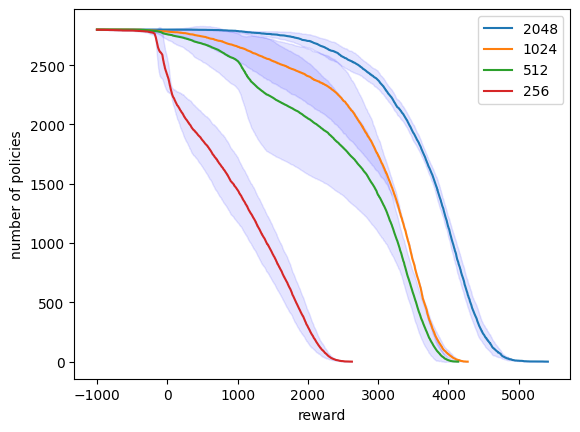

In [9]:
max_num_seeds = 4

# clear the plot
plt.clf()
train_dir = "train_dir_final/mujoco/mujoco_2048"
plot_cdf(train_dir, max_num_seeds)
train_dir = "train_dir_final/mujoco/mujoco_1024"
plot_cdf(train_dir, max_num_seeds)
train_dir = "train_dir_final/mujoco/mujoco_512"
plot_cdf(train_dir, max_num_seeds)
train_dir = "train_dir_final/mujoco/mujoco_256"
plot_cdf(train_dir, max_num_seeds)

plt.legend()

